In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())


Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling', 
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling', 
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        CoExpression           PCC           PPI  Root10DaysSeedling  \
count  41110.000000  41110.000000  41110.000000        41110.000000   
mean       0.991997     -0.361737      0.914668           -0.522040   
std        0.089101      0.463979      0.279379            0.498568   
min        0.000000     -1.000000      0.000000           -1.000000   
25%        1.000000     -0.747963      1.000000           -0.901371   
50%        1.000000     -0.449089      1.000000           -0.663664   
75%        1.000000     -0.051646      1.000000           -0.378497   
max        1.000000      1.000000      1.000000            1.000000   

       Leaf21DaysSeedling  Leaf45DaysOldPlant  log_2FoldChange            ET  \
count        41110.000000        41110.000000     41110.000000  41110.000000   
mean            -0.828778           -0.585144        -0.037332      1.407395   
std              0.327542            0.399046         0.39

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


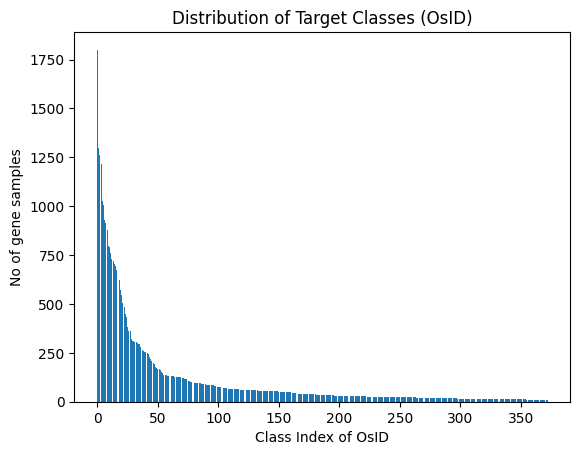

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=20, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 8s 3ms/step - loss: 5.0983 - accuracy: 0.0415 - val_loss: 5.0695 - val_accuracy: 0.0436
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9837 - accuracy: 0.0440 - val_loss: 5.0399 - val_accuracy: 0.0436
Epoch 3/20
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9769 - accuracy: 0.0440 - val_loss: 5.0387 - val_accuracy: 0.0436
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.9737 - accuracy: 0.0440 - val_loss: 5.0382 - val_accuracy: 0.0436
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9700 - accuracy: 0.0440 - val_loss: 5.0508 - val_accuracy: 0.0436
Epoch 6/20
1846/1846 [==============================] - 5s 2ms/step - loss: 4.9663 - accuracy: 0.0440 - val_loss: 5.0350 - val_accuracy: 0.0436
Epoch 7/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9650 - accuracy: 0.044

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 4ms/step - loss: 5.0950 - accuracy: 0.0426 - val_loss: 5.0573 - val_accuracy: 0.0436
Epoch 2/20
1846/1846 [==============================] - 8s 5ms/step - loss: 4.9827 - accuracy: 0.0426 - val_loss: 5.0391 - val_accuracy: 0.0436
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9756 - accuracy: 0.0439 - val_loss: 5.0403 - val_accuracy: 0.0436
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9702 - accuracy: 0.0426 - val_loss: 5.0316 - val_accuracy: 0.0436
Epoch 5/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9690 - accuracy: 0.0440 - val_loss: 5.0320 - val_accuracy: 0.0436
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.9619 - accuracy: 0.0448 - val_loss: 5.0300 - val_accuracy: 0.0436
Epoch 7/20
1846/1846 [==============================] - 8s 5ms/step - loss: 4.9373 - accuracy: 0.0490 - val_loss: 4.9795 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 16s 6ms/step - loss: 5.1020 - accuracy: 0.0423 - val_loss: 5.0390 - val_accuracy: 0.0271
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.9647 - accuracy: 0.0508 - val_loss: 4.9660 - val_accuracy: 0.0706
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.7876 - accuracy: 0.0758 - val_loss: 4.8046 - val_accuracy: 0.0706
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.6818 - accuracy: 0.0778 - val_loss: 4.7636 - val_accuracy: 0.0761
Epoch 5/20
1846/1846 [==============================] - 9s 5ms/step - loss: 4.6251 - accuracy: 0.0822 - val_loss: 4.7104 - val_accuracy: 0.0801
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.5963 - accuracy: 0.0834 - val_loss: 4.6955 - val_accuracy: 0.0803
Epoch 7/20
1846/1846 [==============================] - 9s 5ms/step - loss: 4.5767 - accuracy: 0.0832 - val_loss: 4.6837 - val_accu

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 16s 7ms/step - loss: 5.0321 - accuracy: 0.0466 - val_loss: 4.8734 - val_accuracy: 0.0750
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.4392 - accuracy: 0.0996 - val_loss: 4.3012 - val_accuracy: 0.1219
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.0640 - accuracy: 0.1344 - val_loss: 4.0602 - val_accuracy: 0.1285
Epoch 4/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.8019 - accuracy: 0.1638 - val_loss: 3.8158 - val_accuracy: 0.1677
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.5239 - accuracy: 0.2075 - val_loss: 3.6288 - val_accuracy: 0.2301
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.2910 - accuracy: 0.2496 - val_loss: 3.4422 - val_accuracy: 0.2341
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.0908 - accuracy: 0.2643 - val_loss: 3.2899 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 5ms/step - loss: 5.0647 - accuracy: 0.0429 - val_loss: 4.9344 - val_accuracy: 0.0623
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.4520 - accuracy: 0.0976 - val_loss: 4.2442 - val_accuracy: 0.1239
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.9775 - accuracy: 0.1456 - val_loss: 3.9460 - val_accuracy: 0.1859
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.6438 - accuracy: 0.1889 - val_loss: 3.6517 - val_accuracy: 0.2020
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.3092 - accuracy: 0.2484 - val_loss: 3.3574 - val_accuracy: 0.2768
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.9675 - accuracy: 0.3100 - val_loss: 3.0273 - val_accuracy: 0.3575
Epoch 7/20
1846/1846 [==============================] - 9s 5ms/step - loss: 2.6485 - accuracy: 0.3672 - val_loss: 2.7817 - val_acc

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 5.0144 - accuracy: 0.0419 - val_loss: 4.8011 - val_accuracy: 0.0900
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.2542 - accuracy: 0.1567 - val_loss: 3.9090 - val_accuracy: 0.2088
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.4189 - accuracy: 0.2884 - val_loss: 3.2446 - val_accuracy: 0.3219
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.8009 - accuracy: 0.3838 - val_loss: 2.7559 - val_accuracy: 0.4497
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.3020 - accuracy: 0.4776 - val_loss: 2.3821 - val_accuracy: 0.5241
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.9219 - accuracy: 0.5537 - val_loss: 2.0713 - val_accuracy: 0.5828
Epoch 7/20
1846/1846 [==============================] - 11s 6ms/step - loss: 1.6450 - accuracy: 0.5982 - val_loss: 1.8944 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 16s 7ms/step - loss: 5.0095 - accuracy: 0.0470 - val_loss: 4.7724 - val_accuracy: 0.0748
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.3997 - accuracy: 0.1123 - val_loss: 4.2602 - val_accuracy: 0.1573
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.7805 - accuracy: 0.2094 - val_loss: 3.6584 - val_accuracy: 0.2436
Epoch 4/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.1923 - accuracy: 0.3000 - val_loss: 3.1041 - val_accuracy: 0.3534
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.6926 - accuracy: 0.3777 - val_loss: 2.7429 - val_accuracy: 0.4084
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.3133 - accuracy: 0.4487 - val_loss: 2.4972 - val_accuracy: 0.4722
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.0473 - accuracy: 0.4935 - val_loss: 2.3418 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.7623 - accuracy: 0.0483 - val_loss: 4.5076 - val_accuracy: 0.0704
Epoch 2/20
1846/1846 [==============================] - 11s 6ms/step - loss: 4.2958 - accuracy: 0.0762 - val_loss: 4.1861 - val_accuracy: 0.1025
Epoch 3/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.9091 - accuracy: 0.1434 - val_loss: 3.8364 - val_accuracy: 0.1569
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.5028 - accuracy: 0.2039 - val_loss: 3.4378 - val_accuracy: 0.2323
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.1575 - accuracy: 0.2579 - val_loss: 3.1398 - val_accuracy: 0.2480
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.8656 - accuracy: 0.2990 - val_loss: 2.8914 - val_accuracy: 0.3006
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.6035 - accuracy: 0.3383 - val_loss: 2.6573 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.7479 - accuracy: 0.0515 - val_loss: 4.5310 - val_accuracy: 0.0854
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.3130 - accuracy: 0.0784 - val_loss: 4.3081 - val_accuracy: 0.0953
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 4.0587 - accuracy: 0.1134 - val_loss: 4.0645 - val_accuracy: 0.1393
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.8197 - accuracy: 0.1474 - val_loss: 3.8201 - val_accuracy: 0.1468
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.5764 - accuracy: 0.1688 - val_loss: 3.5913 - val_accuracy: 0.1688
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.3296 - accuracy: 0.1952 - val_loss: 3.3540 - val_accuracy: 0.2064
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.1207 - accuracy: 0.2184 - val_loss: 3.1786 - val_acc

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 18s 6ms/step - loss: 4.8390 - accuracy: 0.0449 - val_loss: 4.6346 - val_accuracy: 0.0491
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.4208 - accuracy: 0.0672 - val_loss: 4.3230 - val_accuracy: 0.0937
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.0917 - accuracy: 0.1021 - val_loss: 4.0314 - val_accuracy: 0.1014
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.7702 - accuracy: 0.1388 - val_loss: 3.7040 - val_accuracy: 0.1518
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.3704 - accuracy: 0.2080 - val_loss: 3.2964 - val_accuracy: 0.2480
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 2.9004 - accuracy: 0.3008 - val_loss: 2.8784 - val_accuracy: 0.3353
Epoch 7/20
1846/1846 [==============================] - 11s 6ms/step - loss: 2.5142 - accuracy: 0.3796 - val_loss: 2.5562 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.7750 - accuracy: 0.0570 - val_loss: 4.4727 - val_accuracy: 0.0994
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.1592 - accuracy: 0.1096 - val_loss: 4.0310 - val_accuracy: 0.1179
Epoch 3/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.7620 - accuracy: 0.1424 - val_loss: 3.7125 - val_accuracy: 0.1439
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.4681 - accuracy: 0.1780 - val_loss: 3.4793 - val_accuracy: 0.1703
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.2359 - accuracy: 0.2154 - val_loss: 3.2776 - val_accuracy: 0.2473
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 3.0340 - accuracy: 0.2522 - val_loss: 3.1139 - val_accuracy: 0.2442
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.8159 - accuracy: 0.2821 - val_loss: 2.8746 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 15s 6ms/step - loss: 4.7706 - accuracy: 0.0569 - val_loss: 4.4995 - val_accuracy: 0.0860
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.1928 - accuracy: 0.0995 - val_loss: 4.0864 - val_accuracy: 0.1094
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.8223 - accuracy: 0.1372 - val_loss: 3.7762 - val_accuracy: 0.1474
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.5352 - accuracy: 0.1692 - val_loss: 3.5379 - val_accuracy: 0.1881
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.2813 - accuracy: 0.2037 - val_loss: 3.2981 - val_accuracy: 0.2172
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.0459 - accuracy: 0.2443 - val_loss: 3.0662 - val_accuracy: 0.2438
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.8023 - accuracy: 0.2944 - val_loss: 2.8908 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 5ms/step - loss: 4.8053 - accuracy: 0.0501 - val_loss: 4.5635 - val_accuracy: 0.0653
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 4.2623 - accuracy: 0.1002 - val_loss: 4.1141 - val_accuracy: 0.1124
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.8453 - accuracy: 0.1437 - val_loss: 3.7990 - val_accuracy: 0.1648
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.5774 - accuracy: 0.1735 - val_loss: 3.6081 - val_accuracy: 0.1965
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.3732 - accuracy: 0.1946 - val_loss: 3.4354 - val_accuracy: 0.1864
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.1886 - accuracy: 0.2251 - val_loss: 3.2578 - val_accuracy: 0.2352
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.9970 - accuracy: 0.2632 - val_loss: 3.0841 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.7377 - accuracy: 0.0608 - val_loss: 4.4231 - val_accuracy: 0.0867
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 4.0650 - accuracy: 0.1176 - val_loss: 3.9390 - val_accuracy: 0.1274
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.7026 - accuracy: 0.1464 - val_loss: 3.7410 - val_accuracy: 0.1428
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.4492 - accuracy: 0.1729 - val_loss: 3.4663 - val_accuracy: 0.2004
Epoch 5/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.2448 - accuracy: 0.1956 - val_loss: 3.2867 - val_accuracy: 0.2141
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.0689 - accuracy: 0.2155 - val_loss: 3.1502 - val_accuracy: 0.2361
Epoch 7/20
1846/1846 [==============================] - 9s 5ms/step - loss: 2.8828 - accuracy: 0.2525 - val_loss: 2.9832 - val_accura

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.8067 - accuracy: 0.0550 - val_loss: 4.4263 - val_accuracy: 0.0689
Epoch 2/20
1846/1846 [==============================] - 13s 7ms/step - loss: 4.0798 - accuracy: 0.1211 - val_loss: 3.9504 - val_accuracy: 0.1397
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6847 - accuracy: 0.1633 - val_loss: 3.6266 - val_accuracy: 0.1650
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.3666 - accuracy: 0.2049 - val_loss: 3.3778 - val_accuracy: 0.2064
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0411 - accuracy: 0.2688 - val_loss: 3.0472 - val_accuracy: 0.2931
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.7181 - accuracy: 0.3465 - val_loss: 2.7729 - val_accuracy: 0.3586
Epoch 7/20
1846/1846 [==============================] - 8s 5ms/step - loss: 2.3998 - accuracy: 0.4144 - val_loss: 2.4848 - val_accurac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 15s 6ms/step - loss: 4.7780 - accuracy: 0.0643 - val_loss: 4.4550 - val_accuracy: 0.0939
Epoch 2/20
1846/1846 [==============================] - 9s 5ms/step - loss: 4.0827 - accuracy: 0.1229 - val_loss: 3.9405 - val_accuracy: 0.1327
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.6969 - accuracy: 0.1676 - val_loss: 3.6664 - val_accuracy: 0.1470
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.4365 - accuracy: 0.1857 - val_loss: 3.4439 - val_accuracy: 0.1943
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 3.2047 - accuracy: 0.2200 - val_loss: 3.2554 - val_accuracy: 0.2389
Epoch 6/20
1846/1846 [==============================] - 9s 5ms/step - loss: 2.9733 - accuracy: 0.2600 - val_loss: 3.0334 - val_accuracy: 0.2977
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.7360 - accuracy: 0.3057 - val_loss: 2.8442 - val_accu

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 5ms/step - loss: 4.8065 - accuracy: 0.0595 - val_loss: 4.4910 - val_accuracy: 0.1028
Epoch 2/20
1846/1846 [==============================] - 9s 5ms/step - loss: 4.1637 - accuracy: 0.1207 - val_loss: 4.0196 - val_accuracy: 0.1413
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7616 - accuracy: 0.1599 - val_loss: 3.7353 - val_accuracy: 0.1639
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5070 - accuracy: 0.1882 - val_loss: 3.6123 - val_accuracy: 0.1509
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3083 - accuracy: 0.2113 - val_loss: 3.3723 - val_accuracy: 0.1903
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0841 - accuracy: 0.2473 - val_loss: 3.1535 - val_accuracy: 0.2585
Epoch 7/20
1846/1846 [==============================] - 8s 4ms/step - loss: 2.8346 - accuracy: 0.3031 - val_loss: 2.9251 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 19s 8ms/step - loss: 4.8261 - accuracy: 0.0617 - val_loss: 4.4856 - val_accuracy: 0.1023
Epoch 2/20
1846/1846 [==============================] - 16s 9ms/step - loss: 4.0601 - accuracy: 0.1368 - val_loss: 3.8964 - val_accuracy: 0.1839
Epoch 3/20
1846/1846 [==============================] - 16s 9ms/step - loss: 3.6319 - accuracy: 0.1918 - val_loss: 3.6142 - val_accuracy: 0.1985
Epoch 4/20
1846/1846 [==============================] - 15s 8ms/step - loss: 3.3548 - accuracy: 0.2233 - val_loss: 3.3802 - val_accuracy: 0.2354
Epoch 5/20
1846/1846 [==============================] - 13s 7ms/step - loss: 3.1143 - accuracy: 0.2570 - val_loss: 3.1702 - val_accuracy: 0.2878
Epoch 6/20
1846/1846 [==============================] - 13s 7ms/step - loss: 2.8726 - accuracy: 0.2907 - val_loss: 2.9474 - val_accuracy: 0.2840
Epoch 7/20
1846/1846 [==============================] - 13s 7ms/step - loss: 2.6262 - accuracy: 0.3426 - val_loss: 2.7227 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 11s 4ms/step - loss: 4.9155 - accuracy: 0.0478 - val_loss: 4.6693 - val_accuracy: 0.0506
Epoch 2/20
1846/1846 [==============================] - 8s 4ms/step - loss: 4.2538 - accuracy: 0.1087 - val_loss: 3.9938 - val_accuracy: 0.1549
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 3.6696 - accuracy: 0.1741 - val_loss: 3.6020 - val_accuracy: 0.1560
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 3.3319 - accuracy: 0.2169 - val_loss: 3.3495 - val_accuracy: 0.2295
Epoch 5/20
1846/1846 [==============================] - 13s 7ms/step - loss: 3.0401 - accuracy: 0.2615 - val_loss: 3.0750 - val_accuracy: 0.3043
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.7219 - accuracy: 0.3348 - val_loss: 2.8160 - val_accuracy: 0.3712
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 2.4232 - accuracy: 0.4132 - val_loss: 2.5345 - val_accu

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 5ms/step - loss: 4.9608 - accuracy: 0.0431 - val_loss: 4.7692 - val_accuracy: 0.0493
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 4.3823 - accuracy: 0.0844 - val_loss: 4.1047 - val_accuracy: 0.1448
Epoch 3/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7403 - accuracy: 0.1758 - val_loss: 3.6373 - val_accuracy: 0.1872
Epoch 4/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3274 - accuracy: 0.2284 - val_loss: 3.3062 - val_accuracy: 0.2530
Epoch 5/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9773 - accuracy: 0.2938 - val_loss: 3.0411 - val_accuracy: 0.3406
Epoch 6/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6504 - accuracy: 0.3679 - val_loss: 2.7089 - val_accuracy: 0.3947
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3618 - accuracy: 0.4156 - val_loss: 2.4720 - val_accuracy

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

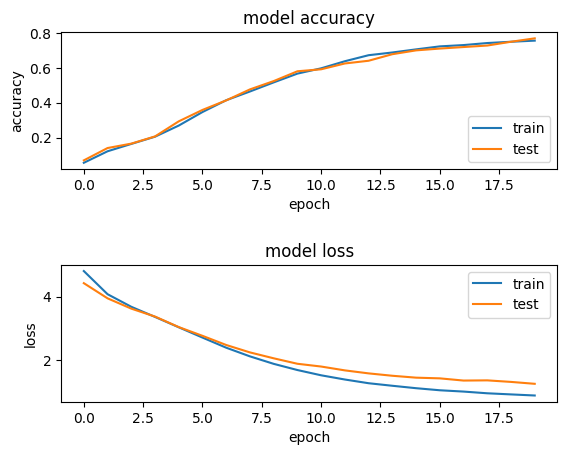

Final Test Accuracy: 0.7793911695480347


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       591
           1       0.92      1.00      0.96       430
           2       0.98      1.00      0.99       419
           3       0.96      1.00      0.98       384
           4       0.82      1.00      0.90       339
           5       0.99      1.00      1.00       342
           6       0.99      1.00      1.00       310
           7       1.00      0.96      0.98       325
           8       0.64      0.96      0.77       294
           9       0.96      0.99      0.97       269
          10       1.00      1.00      1.00       296
          11       0.89      1.00      0.94       258
          12       0.96      1.00      0.98       247
          13       0.91      0.99      0.95       237
          14       0.88      0.96      0.92       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os04g0475500         328              191       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               21       False
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.045
1,2,0.057
2,3,0.089
3,4,0.383
4,5,0.614
5,6,0.746
6,7,0.749
7,8,0.720
8,9,0.644
9,10,0.746
